# Master equation model of the alanine pentapeptide

In this example we deal with a simple but realistic example of MD simulation data, generated with the [Gromacs package](http://www.gromacs.org/).
First we import a number of general purpose Python libraries we will need as we run this example


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.2)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

### Discretizing the trajectory
We start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of interesting methods for parsing and calculating interestign properties of our time-series data.

In [5]:
from mastermsm.trajectory import traj
import mdtraj as md

In [6]:
tr = traj.TimeSeries(top='data/ala5_protein.gro',\
                     traj=['data/ala5_amber03star_tip3p_tip3p_protein.xtc'])
tr.mdt

<mdtraj.Trajectory with 400001 frames, 59 atoms, 7 residues, and unitcells at 0x7f3bf2e779e8>

For example, we can access the $\phi$ and $\psi$ dihedrals for each of the aminoacids, which we will use in our discretization.

In [7]:
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

For each of the amino acids, we visualize the distribution of Ramachandran angles.

Text(0, 0.5, '$\\psi$')

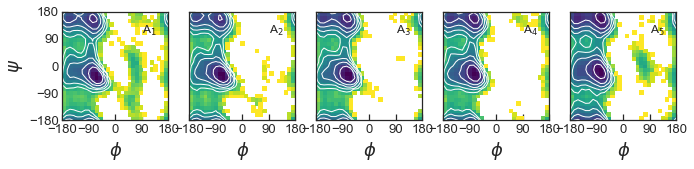

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(11,2), sharex=True, sharey=True)
k = 0
for i in range(5):
    counts, ybins, xbins, image = ax[i].hist2d(180./np.pi*phi[1][:,k],180./np.pi*psi[1][:,k], \
                bins=[np.linspace(-180,180,30), np.linspace(-180,180,30)], \
                cmap='viridis_r', \
                norm=mpl.colors.LogNorm(), normed=True)
    ax[i].contour(np.transpose(counts), extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], \
                  linewidths=1, levels = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4], colors='white')
    ax[i].set_xlim(-180,180)
    ax[i].set_ylim(-180,180)
    ax[i].xaxis.set_ticks(range(-180,181,90))
    ax[i].yaxis.set_ticks(range(-180,181,90))
    ax[i].text(0.75, 0.8, "A$_%g$"%(k+1), fontsize=12, transform=ax[i].transAxes)
    ax[i].set_xlabel(r'$\phi$', fontsize=18)
    k +=1
ax[0].set_ylabel(r'$\psi$', fontsize=18)

We resort to a built in method in the ```TimeSeries``` class for discretizing peptides based on torsion angles. Given the low population in the left-handed helix, we will simply use to states (A and E, for alpha and extended, respectively).

In [ ]:
tr.discretize(states=['A', 'E'])

Now we check whether the discretization has captured the relevant dynamics at the single amino acid level. We look into residue 2, which remains fairly helical during the simulation timescale, and residue 8, which fluctuates a lot.

Text(0.5, 0, 'Time [ps]')

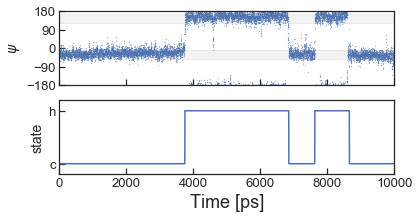

In [ ]:
i = 2
y = [0 if x[i] == 'A' else 1 for x in tr.distraj]

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,3))
ax1.plot(psi[1][:,i]*180/np.pi,'o', markersize=0.2)
ax2.plot(y)
ax1.set_xlim(0,5000)
ax1.set_ylim(-180,180)
ax1.yaxis.set_ticks(range(-180,181,90))
ax1.set_ylabel(r'$\psi$', fontsize=14)

ax2.set_ylabel(r'state', fontsize=14)
ax2.set_xlim(0,10000)
ax2.set_ylim(-0.2,1.2)
ax2.yaxis.set_ticks([0,1])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'c'
labels[1] = 'h'
ax2.set_yticklabels(labels)
ax1.fill_between([0, 10000], -10, -50, alpha=0.1, color='gray')
ax1.fill_between([0, 10000], 165, 125, alpha=0.1, color='gray')

ax2.set_xlabel('Time [ps]')
ax2.set_xlabel(r'Time [ps]', fontsize=18)


Then we use the ```find_keys``` method from the ```TimeSeries``` objects to find the discrete states in the trajectory. Also, we sort the state names for convenience.

In [ ]:
tr.find_keys()
tr.keys.sort()
tr.keys.reverse()
print ([x for x in tr.keys])

['EEEEE', 'EEEEA', 'EEEAE', 'EEEAA', 'EEAEE', 'EEAEA', 'EEAAE', 'EEAAA', 'EAEEE', 'EAEEA', 'EAEAE', 'EAEAA', 'EAAEE', 'EAAEA', 'EAAAE', 'EAAAA', 'AEEEE', 'AEEEA', 'AEEAE', 'AEEAA', 'AEAEE', 'AEAEA', 'AEAAE', 'AEAAA', 'AAEEE', 'AAEEA', 'AAEAE', 'AAEAA', 'AAAEE', 'AAAEA', 'AAAAE', 'AAAAA']


### Master equation model
Having discretized the trajectory onto 32 microstates, we can use it to construct the dynamical model using the ```msm``` module. In particular, the ```SuperMSM``` class helps coordinate the construction of many MSMs.

In [ ]:
from mastermsm.msm import msm
msm_ala5 = msm.SuperMSM([tr])


 Building MSM from 
 [['data/ala5_amber03star_tip3p_tip3p_protein.xtc']]
     # states: 32


First of all, we carry out the most standard test for lifetime convergence, so that we learn which lag time is adequeate for recovering meaningful results.

In [ ]:
msm_ala5.convergence_test(time=[1, 3, 10, 30, 100, 300], error=True)

In [ ]:
fig, ax = plt.subplots()
for i in range(6):
    tau_vs_lagt = np.array([[x,msm_ala5.msms[x].tauT[i],msm_ala5.msms[x].tau_std[i]] \
               for x in sorted(msm_ala5.msms.keys())])
    ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=7)
#ax.plot(tau_vs_lagt[:,0],tau_vs_lagt[:,0])
ax.fill_between(10**np.arange(-0.2,4,0.2), 1e-1, 10**np.arange(-0.2,4,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau_i$ [ps]', fontsize=16)
ax.set_xlim(0.5,800)
ax.set_ylim(0,3e3)
_ = ax.set_xscale('log')
#_ = ax.set_yscale('log')

It seems that from very early on, the relaxation times of the model are pretty well converged.

### Analysis of the results
After chosing a lag time of 10 ps, we take a closer look at the eigenvalue spectrum.

In [ ]:
lagt = 10
msm_ala5.msms[lagt].do_trans(evecs=True)

fig, ax = plt.subplots()
ax.errorbar(range(1,len(msm_ala5.msms[lagt].tauT)+1),msm_ala5.msms[lagt].tauT, fmt='o-', \
            yerr= msm_ala5.msms[lagt].tau_std, ms=7)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$')
ax.set_ylim(0, 2100)
ax.set_xlim(0, 32)
plt.tight_layout()

Clearly there is a gap between the slowest relaxation time and the next one. We can take a look at the eigenvectors to recover information about the equilibrium distribution and the dynamical process associated with the slowest mode. The first right eigenvector provides information about the equilibrium distribution, which we can recover with proper normalization in the ```peqT``` attribute of the ```MSM``` object. The second left eigenvector, corresponding to the first non-zero eigenvalue, shows which state equilibrate at the corresponding relaxation time.

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].errorbar(range(len(msm_ala5.msms[lagt].peqT)), msm_ala5.msms[lagt].peqT, \
               msm_ala5.msms[lagt].peq_std, fmt='-')
ax[0].fill_between(range(len(msm_ala5.msms[lagt].peqT)), \
                   msm_ala5.msms[lagt].peqT, 0, alpha=0.5)
ax[0].set_ylim(0,0.25)

ax[1].plot(msm_ala5.msms[lagt].lvecsT[:,1])
ax[1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1].fill_between(range(len(msm_ala5.msms[lagt].lvecsT[:,1])), \
                   msm_ala5.msms[lagt].lvecsT[:,1], 0, alpha=0.5)
ax[1].set_xlim(-0.5,31.5)
ax[1].set_xticks(range(0,32))
ax[1].set_xticklabels(msm_ala5.keys, rotation='vertical', fontsize=10)

ax[0].set_ylabel("$p_{eq}$")
ax[1].set_ylabel("$\Psi^L_1$")
plt.tight_layout(h_pad=0)

The results are interesting. The equilibrium distribution shows that the ```AAAAA``` microstate is the most stable for this particular force field. as it shows how helical states (all those containing an alpha-helix nucleus of ```AAA``` starting at positions 1 or 2) exchange with the states richer in extended conformation (i.e. having more ```E``` residues).

In [ ]:
msm_ala5.do_lbrate()
msm_ala5.msms[lagt].do_rate()

In [ ]:
lagt = 10

fig, ax = plt.subplots()
ax.errorbar(range(1,len(msm_ala5.msms[lagt].tauT)+1),msm_ala5.msms[lagt].tauT, fmt='o-', \
            yerr= msm_ala5.msms[lagt].tau_std, ms=7)
ax.plot(range(1,len(msm_ala5.keys)), msm_ala5.msms[lagt].tauK, 's-', markersize=10, alpha=0.5)
ax.plot(range(1,len(msm_ala5.keys)), msm_ala5.tauK, 'x-', markersize=10)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$ (ps)')
ax.set_ylim(0, 2200)
ax.set_xlim(0, 32)
plt.tight_layout()

In [ ]:
msm_ala5.msms[lagt].do_pfold(UU="EEEEE", FF="AAAAA")

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(len(msm_ala5.keys)), msm_ala5.msms[lagt].pfold-0.5)
ax.set_xticks(range(0,32))
ax.set_xticklabels(msm_ala5.keys, rotation='vertical', fontsize=10)
ax.set_ylabel(r'$p_{fold}$')
ax.set_yticks(np.arange(-0.5,0.6,0.25))
ax.set_yticklabels(np.arange(0.,1.1,0.25))
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-1, 32)
ax.axhline(0, ls='--', color='gray', lw=1)
plt.tight_layout()

In [ ]:
plt.plot(msm_ala5.msms[lagt].lvecsT[:,1], msm_ala5.msms[lagt].pfold, 'o')
ax.set_ylabel(r'$p_{fold}$')

In [ ]:
msm_ala5.msms[lagt].sensitivity(UU="EEEEE", FF="AAAAA")

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(len(msm_ala5.keys)), msm_ala5.msms[lagt].d_lnkf)
plt.fill_between(range(0,32), msm_ala5.msms[lagt].d_lnkf, color='gray', alpha=0.2)
ax.set_xticks(range(0,32))
_ = ax.set_xticklabels(msm_ala5.keys, rotation='vertical', fontsize=10)

In [ ]:
tcum, popul = msm_ala5.msms[lagt].propagateT(init="EEEEE")

In [ ]:
fig, ax = plt.subplots()
ax.plot(tcum, [x[31] for x in popul])
ax.plot(tcum, 1-np.exp([-x*msm_ala5.msms[lagt].kf for x in tcum]))

ax.set_xscale('log')
ax.set_xlabel('Time (ps)')

In [ ]:
msm_ala5.msms[lagt].rate[:,31] = 0
tcum, popul = msm_ala5.msms[lagt].propagateK(init="EEEEE")

In [ ]:
fig, ax = plt.subplots()
ax.plot(tcum, [x[31] for x in popul])
ax.plot(tcum, 1-np.exp([-x*msm_ala5.msms[lagt].kf for x in tcum]))

ax.set_xscale('log')

In [ ]:
from mastermsm.fewsm import fewsm

In [ ]:
fewsm_ala5 = fewsm.FEWSM(msm_ala5.msms[lagt], N=2)

In [ ]:
mappedtraj = fewsm_ala5.map_trajectory()

In [ ]:
def fhelix(s):
    """
    Calculates the fraction helix of the pentapeptide from 
    the number of consecutive helical residues.
    
    Parameters
    ----------
    s : str
        String with assignment to helical (A) and extended (E)
        states.
        
    Returns
    -------
        float
        Value for the fraction helix.

    """
    if s == 'AAAAA':
        return 1
    elif 'AAAA' in s:
        return 0.8
    elif 'AAA' in s:
        return 0.6
    else:
        return 0.

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(3,1, figure=fig, height_ratios=[5, 1, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)

plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

ax0.plot([msm_ala5.keys.index(s) for s in tr.distraj], lw=1.5)

ax1.plot([fhelix(s) for s in tr.distraj], 'orange', lw=1.5)

ax2.plot([1 - x for x in fewsm_ala5.mappedtraj[0].distraj], 'g', lw=1.5)

ax0.set_yticks(range(0,32))
ax0.set_yticklabels(msm_ala5.keys, fontsize=11)
ax0.set_ylim(-0.5,31.5)

ax1.set_yticks(np.arange(0,1.1,0.5))
ax1.set_ylabel(r'$f_{helix}$', fontsize=16)

ax2.set_yticks([0,1])
ax2.set_ylabel('state$_{CG}$', fontsize=16)

ax2.set_xlabel('Time (ps)', fontsize=16)

ax0.set_xlim(0, 50000)

plt.tight_layout(h_pad=-0.25)